In [1]:
!pip install arviz pymc

In [2]:
import numpy as np
import arviz as az
import pymc as pmc
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('white')
colors = sns.color_palette()

import logging
logging.basicConfig()
logger = logging.getLogger('pymc')
logger.setLevel(logging.CRITICAL)

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


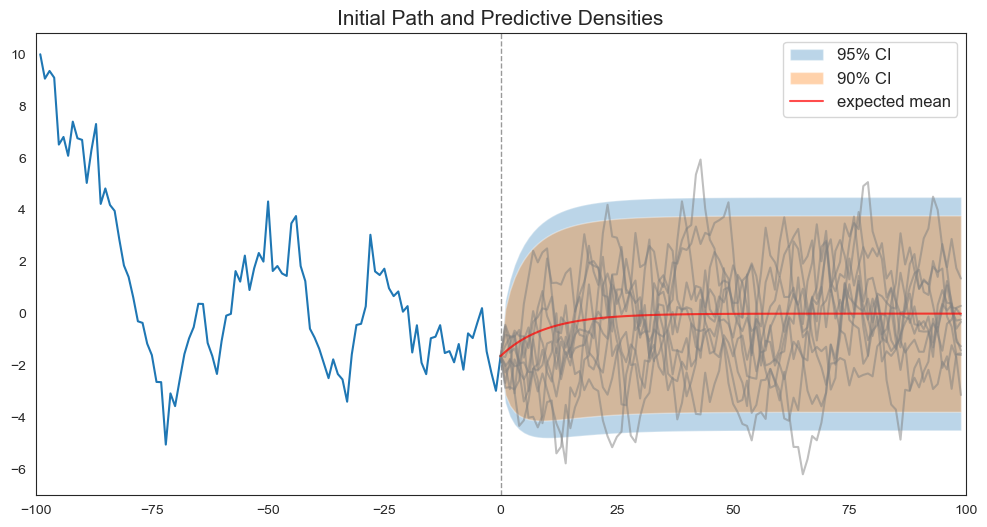

In [3]:
def AR1_simulate(rho, sigma, y0, T):

    # Allocate space and draw epsilons
    y = np.empty(T)
    eps = np.random.normal(0, sigma, T)

    # Initial condition and step forward
    y[0] = y0
    for t in range(1, T):
        y[t] = rho * y[t-1] + eps[t]
        
    return y


def plot_initial_path(initial_path):
    """
    Plot the initial path and the preceding predictive densities
    """
    # Compute .9 confidence interval]
    y0 = initial_path[-1]
    center = np.array([rho**j * y0 for j in range(T1)])
    vars = np.array([sigma**2 * (1 - rho**(2 * j)) / (1 - rho**2) for j in range(T1)])
    y_bounds1_c95, y_bounds2_c95 = center + 1.96 * np.sqrt(vars), center - 1.96 * np.sqrt(vars)
    y_bounds1_c90, y_bounds2_c90 = center + 1.65 * np.sqrt(vars), center - 1.65 * np.sqrt(vars)

    # Plot
    fig, ax = plt.subplots(1, 1, figsize=(12, 6))
    ax.set_title("Initial Path and Predictive Densities", fontsize=15)
    ax.plot(np.arange(-T0 + 1, 1), initial_path)
    ax.set_xlim([-T0, T1])
    ax.axvline(0, linestyle='--', alpha=.4, color='k', lw=1)

    # Simulate future paths
    for i in range(10):
        y_future = AR1_simulate(rho, sigma, y0, T1)
        ax.plot(np.arange(T1), y_future, color='grey', alpha=.5)
    
    # Plot 90% CI
    ax.fill_between(np.arange(T1), y_bounds1_c95, y_bounds2_c95, alpha=.3, label='95% CI')
    ax.fill_between(np.arange(T1), y_bounds1_c90, y_bounds2_c90, alpha=.35, label='90% CI')
    ax.plot(np.arange(T1), center, color='red', alpha=.7, label='expected mean')
    ax.legend(fontsize=12)
    plt.show()


sigma =  1
rho = 0.9
T0, T1 = 100, 100
y0 = 10

# Simulate
np.random.seed(145)
initial_path = AR1_simulate(rho, sigma, y0, T0)

# Plot
plot_initial_path(initial_path)

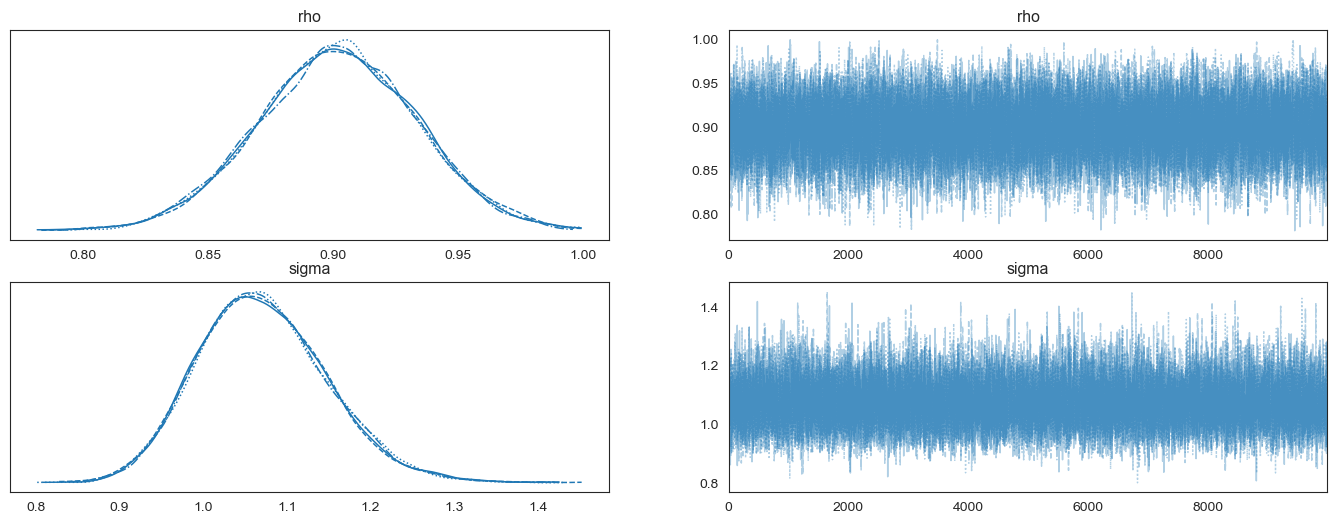

In [4]:
def draw_from_posterior(sample):
    """
    Draw a sample of size N from the posterior distribution.
    """

    AR1_model = pmc.Model()

    with AR1_model:
        
        # Start with priors
        rho = pmc.Uniform('rho',lower=-1.,upper=1.)  # Assume stable rho
        sigma = pmc.HalfNormal('sigma', sigma = np.sqrt(10))

        # Expected value of y at the next period (rho * y)
        yhat = rho * sample[:-1]

        # Likelihood of the actual realization.
        y_like = pmc.Normal('y_obs', mu=yhat, sigma=sigma, observed=sample[1:])

    with AR1_model:
        trace = pmc.sample(10000, tune=5000)

    # check condition
    with AR1_model:
        az.plot_trace(trace, figsize=(17, 6))
    
    rhos = trace.posterior.rho.values.flatten()
    sigmas = trace.posterior.sigma.values.flatten()

    post_sample = {
        'rho': rhos,
        'sigma': sigmas
    }
    
    return post_sample

post_samples = draw_from_posterior(initial_path)

In [5]:
# define statistics
def next_recession(omega):
    n = omega.shape[0] - 3
    z = np.zeros(n, dtype=int)
    
    for i in range(n):
        z[i] = int(omega[i] <= omega[i+1] and omega[i+1] > omega[i+2] and omega[i+2] > omega[i+3])

    if np.any(z) == False:
        return 500
    else:
        return np.where(z==1)[0][0] + 1

def minimum_value(omega):
    return min(omega[:8])

def severe_recession(omega):
    z = np.diff(omega)
    n = z.shape[0]
    
    sr = (z < -.02).astype(int)
    indices = np.where(sr == 1)[0]

    if len(indices) == 0:
        return T1
    else:
        return indices[0] + 1

def next_turning_point(omega):
    """
    Suppose that omega is of length 6
    
        y_{t-2}, y_{t-1}, y_{t}, y_{t+1}, y_{t+2}, y_{t+3}
    
    that is sufficient for determining the value of P/N    
    """
    
    n = np.asarray(omega).shape[0] - 4
    T = np.zeros(n, dtype=int)
    
    for i in range(n):
        if ((omega[i] > omega[i+1]) and (omega[i+1] > omega[i+2]) and 
            (omega[i+2] < omega[i+3]) and (omega[i+3] < omega[i+4])):
            T[i] = 1
        elif ((omega[i] < omega[i+1]) and (omega[i+1] < omega[i+2]) and 
            (omega[i+2] > omega[i+3]) and (omega[i+3] > omega[i+4])):
            T[i] = -1
    
    up_turn = np.where(T == 1)[0][0] + 1 if (1 in T) == True else T1
    down_turn = np.where(T == -1)[0][0] + 1 if (-1 in T) == True else T1

    return up_turn, down_turn

/Users/humphreyyang/anaconda3/envs/quantecon/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/humphreyyang/anaconda3/envs/quantecon/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/humphreyyang/anaconda3/envs/quantecon/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/humphreyyang/anaconda3/envs/quantecon/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na opti

/Users/humphreyyang/anaconda3/envs/quantecon/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/humphreyyang/anaconda3/envs/quantecon/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/humphreyyang/anaconda3/envs/quantecon/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/humphreyyang/anaconda3/envs/quantecon/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na opti

/Users/humphreyyang/anaconda3/envs/quantecon/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/humphreyyang/anaconda3/envs/quantecon/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


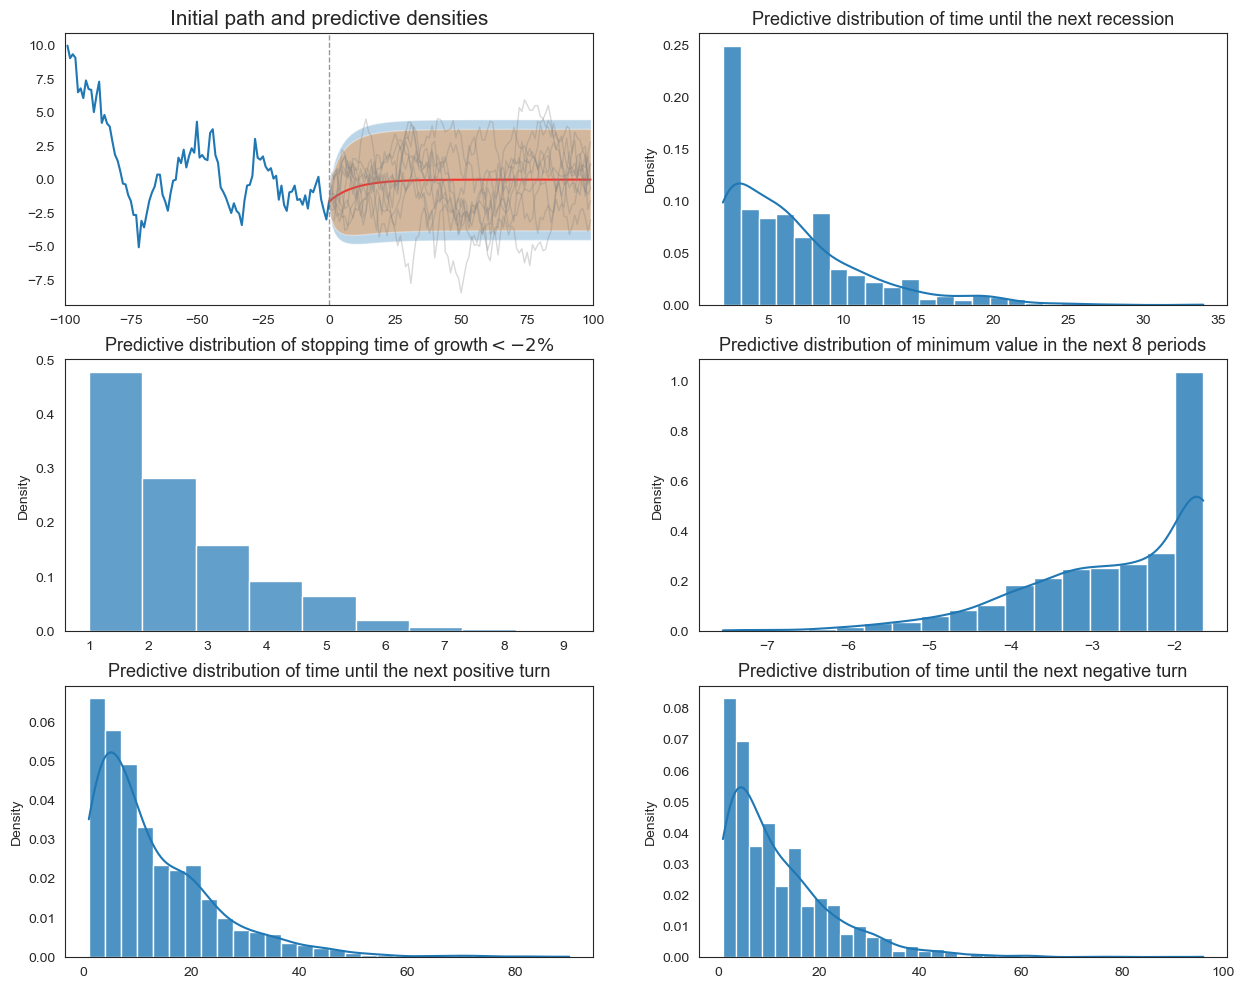

In [6]:
def plot_Wecker(initial_path, N, ax):
    """
    Plot the predictive distributions from "pure" Wecker's method.
    """
    # Store outcomes
    next_reces = np.zeros(N)
    severe_rec = np.zeros(N)
    min_vals = np.zeros(N)
    next_up_turn, next_down_turn = np.zeros(N), np.zeros(N)
    
    # Compute .9 confidence interval]
    y0 = initial_path[-1]
    center = np.array([rho**j * y0 for j in range(T1)])
    vars = np.array([sigma**2 * (1 - rho**(2 * j)) / (1 - rho**2) for j in range(T1)])
    y_bounds1_c95, y_bounds2_c95 = center + 1.96 * np.sqrt(vars), center - 1.96 * np.sqrt(vars)
    y_bounds1_c90, y_bounds2_c90 = center + 1.65 * np.sqrt(vars), center - 1.65 * np.sqrt(vars)

    # Plot
    ax[0, 0].set_title("Initial path and predictive densities", fontsize=15)
    ax[0, 0].plot(np.arange(-T0 + 1, 1), initial_path)
    ax[0, 0].set_xlim([-T0, T1])
    ax[0, 0].axvline(0, linestyle='--', alpha=.4, color='k', lw=1)

    # Plot 90% CI
    ax[0, 0].fill_between(np.arange(T1), y_bounds1_c95, y_bounds2_c95, alpha=.3)
    ax[0, 0].fill_between(np.arange(T1), y_bounds1_c90, y_bounds2_c90, alpha=.35)
    ax[0, 0].plot(np.arange(T1), center, color='red', alpha=.7)

    # Simulate future paths
    for n in range(N):
        sim_path = AR1_simulate(rho, sigma, initial_path[-1], T1)
        next_reces[n] = next_recession(np.hstack([initial_path[-3:-1], sim_path]))
        severe_rec[n] = severe_recession(sim_path)
        min_vals[n] = minimum_value(sim_path)
        next_up_turn[n], next_down_turn[n] = next_turning_point(sim_path)

        if n%(N/10) == 0:
            ax[0, 0].plot(np.arange(T1), sim_path, color='gray', alpha=.3, lw=1)
            
    # Return next_up_turn, next_down_turn
    sns.histplot(next_reces, kde=True, stat='density', ax=ax[0, 1], alpha=.8, label='True parameters')
    ax[0, 1].set_title("Predictive distribution of time until the next recession", fontsize=13)

    sns.histplot(severe_rec, kde=False, stat='density', ax=ax[1, 0], binwidth=0.9, alpha=.7, label='True parameters')
    ax[1, 0].set_title(r"Predictive distribution of stopping time of growth$<-2\%$", fontsize=13)

    sns.histplot(min_vals, kde=True, stat='density', ax=ax[1, 1], alpha=.8, label='True parameters')
    ax[1, 1].set_title("Predictive distribution of minimum value in the next 8 periods", fontsize=13)

    sns.histplot(next_up_turn, kde=True, stat='density', ax=ax[2, 0], alpha=.8, label='True parameters')
    ax[2, 0].set_title("Predictive distribution of time until the next positive turn", fontsize=13)

    sns.histplot(next_down_turn, kde=True, stat='density', ax=ax[2, 1], alpha=.8, label='True parameters')
    ax[2, 1].set_title("Predictive distribution of time until the next negative turn", fontsize=13)

fig, ax = plt.subplots(3, 2, figsize=(15,12))
plot_Wecker(initial_path, 1000, ax)
plt.show()

/Users/humphreyyang/anaconda3/envs/quantecon/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/humphreyyang/anaconda3/envs/quantecon/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/humphreyyang/anaconda3/envs/quantecon/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/humphreyyang/anaconda3/envs/quantecon/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na opti

/Users/humphreyyang/anaconda3/envs/quantecon/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/humphreyyang/anaconda3/envs/quantecon/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/humphreyyang/anaconda3/envs/quantecon/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/humphreyyang/anaconda3/envs/quantecon/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na opti

/Users/humphreyyang/anaconda3/envs/quantecon/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/humphreyyang/anaconda3/envs/quantecon/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


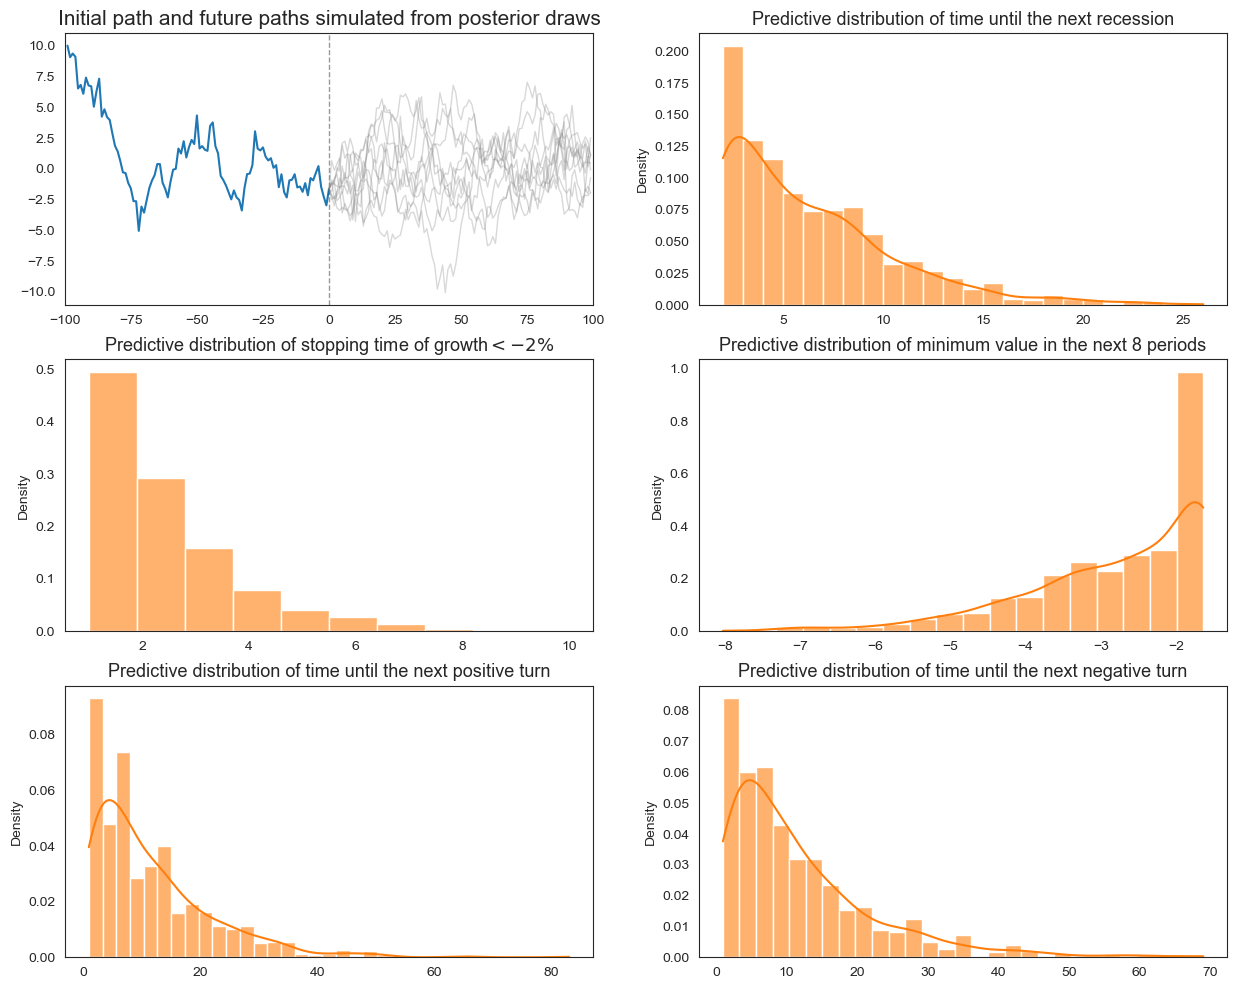

In [7]:
def plot_extended_Wecker(post_samples, initial_path, N, ax):
    """
    Plot the extended Wecker's predictive distribution
    """
    # Select a sample
    index = np.random.choice(np.arange(len(post_samples['rho'])), N + 1, replace=False)
    rho_sample = post_samples['rho'][index]
    sigma_sample = post_samples['sigma'][index]

    # Store outcomes
    next_reces = np.zeros(N)
    severe_rec = np.zeros(N)
    min_vals = np.zeros(N)
    next_up_turn, next_down_turn = np.zeros(N), np.zeros(N)

    # Plot
    ax[0, 0].set_title("Initial path and future paths simulated from posterior draws", fontsize=15)
    ax[0, 0].plot(np.arange(-T0 + 1, 1), initial_path)
    ax[0, 0].set_xlim([-T0, T1])
    ax[0, 0].axvline(0, linestyle='--', alpha=.4, color='k', lw=1)

    # Simulate future paths
    for n in range(N):
        sim_path = AR1_simulate(rho_sample[n], sigma_sample[n], initial_path[-1], T1)
        next_reces[n] = next_recession(np.hstack([initial_path[-3:-1], sim_path]))
        severe_rec[n] = severe_recession(sim_path)
        min_vals[n] = minimum_value(sim_path)
        next_up_turn[n], next_down_turn[n] = next_turning_point(sim_path)

        if n % (N / 10) == 0:
            ax[0, 0].plot(np.arange(T1), sim_path, color='gray', alpha=.3, lw=1)
        
    # Return next_up_turn, next_down_turn
    sns.histplot(next_reces, kde=True, stat='density', ax=ax[0, 1], alpha=.6, color=colors[1], label='Sampling from posterior')
    ax[0, 1].set_title("Predictive distribution of time until the next recession", fontsize=13)

    sns.histplot(severe_rec, kde=False, stat='density', ax=ax[1, 0], binwidth=.9, alpha=.6, color=colors[1], label='Sampling from posterior')
    ax[1, 0].set_title(r"Predictive distribution of stopping time of growth$<-2\%$", fontsize=13)

    sns.histplot(min_vals, kde=True, stat='density', ax=ax[1, 1], alpha=.6, color=colors[1], label='Sampling from posterior')
    ax[1, 1].set_title("Predictive distribution of minimum value in the next 8 periods", fontsize=13)

    sns.histplot(next_up_turn, kde=True, stat='density', ax=ax[2, 0], alpha=.6, color=colors[1], label='Sampling from posterior')
    ax[2, 0].set_title("Predictive distribution of time until the next positive turn", fontsize=13)

    sns.histplot(next_down_turn, kde=True, stat='density', ax=ax[2, 1], alpha=.6, color=colors[1], label='Sampling from posterior')
    ax[2, 1].set_title("Predictive distribution of time until the next negative turn", fontsize=13)

fig, ax = plt.subplots(3, 2, figsize=(15, 12))
plot_extended_Wecker(post_samples, initial_path, 1000, ax)
plt.show()

/Users/humphreyyang/anaconda3/envs/quantecon/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/humphreyyang/anaconda3/envs/quantecon/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/humphreyyang/anaconda3/envs/quantecon/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/humphreyyang/anaconda3/envs/quantecon/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na opti

/Users/humphreyyang/anaconda3/envs/quantecon/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/humphreyyang/anaconda3/envs/quantecon/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/humphreyyang/anaconda3/envs/quantecon/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/humphreyyang/anaconda3/envs/quantecon/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na opti

/Users/humphreyyang/anaconda3/envs/quantecon/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/humphreyyang/anaconda3/envs/quantecon/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


/Users/humphreyyang/anaconda3/envs/quantecon/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/humphreyyang/anaconda3/envs/quantecon/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/humphreyyang/anaconda3/envs/quantecon/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/humphreyyang/anaconda3/envs/quantecon/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na opti

/Users/humphreyyang/anaconda3/envs/quantecon/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/humphreyyang/anaconda3/envs/quantecon/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/humphreyyang/anaconda3/envs/quantecon/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/humphreyyang/anaconda3/envs/quantecon/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na opti

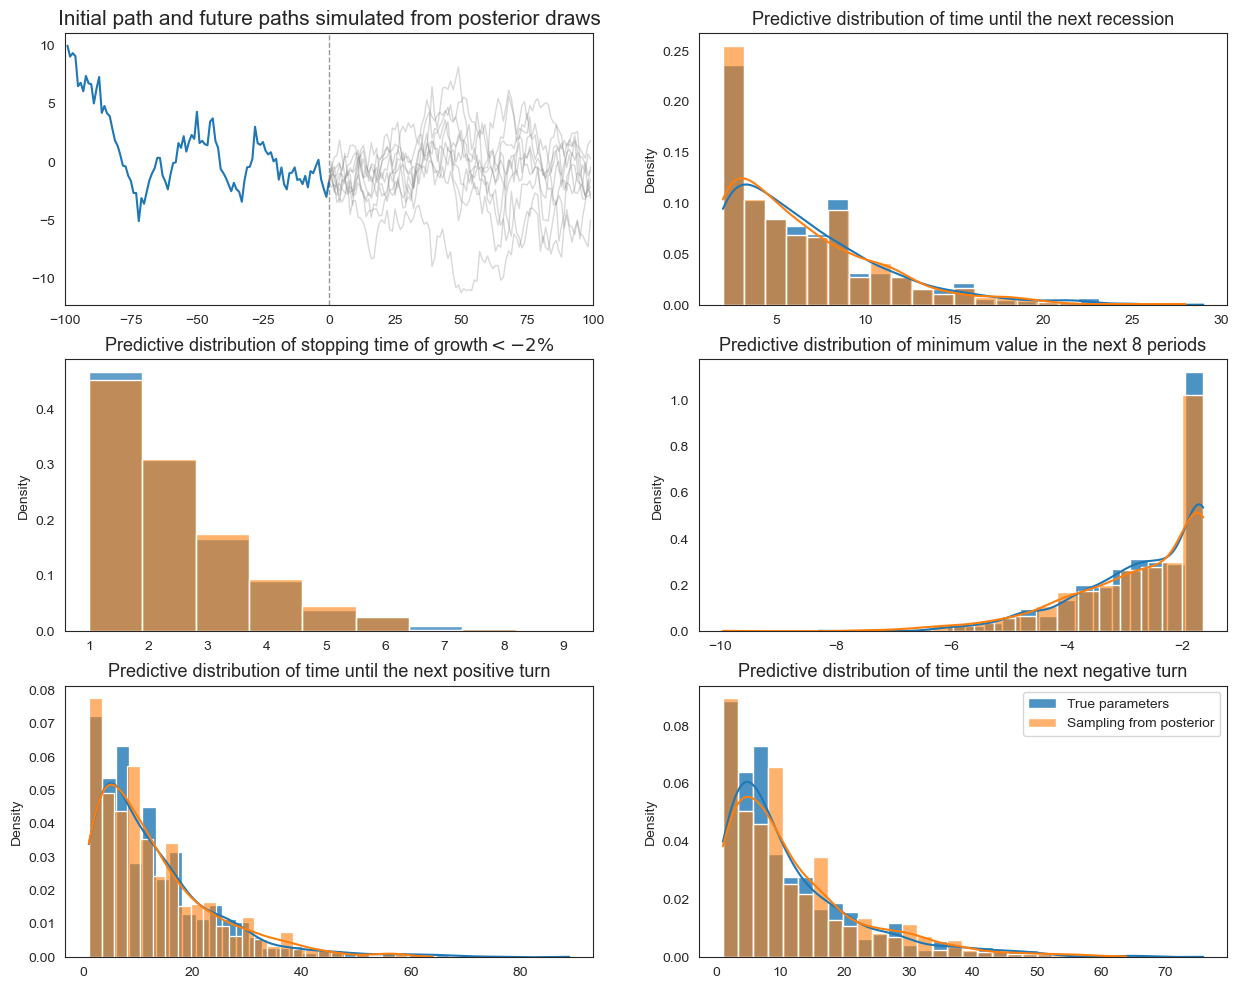

In [8]:
fig, ax = plt.subplots(3, 2, figsize=(15,12))
plot_Wecker(initial_path, 1000, ax)
ax[0, 0].clear()
plot_extended_Wecker(post_samples, initial_path, 1000, ax)
plt.legend()
plt.show()